<a href="https://colab.research.google.com/github/ajipurnama25/mldeploy/blob/main/Model_InceptionResNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d vbookshelf/rice-leaf-diseases

 46% 17.0M/36.7M [00:00<00:00, 53.1MB/s]
100% 36.7M/36.7M [00:00<00:00, 80.6MB/s]


In [4]:

!unzip rice-leaf-diseases.zip

Archive:  rice-leaf-diseases.zip
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0365.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0366.jpg  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0367.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0370.jpg  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0372.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0373.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0374.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0375.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0376.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0377.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0378.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0379.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0380.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0381.JPG  
 

In [5]:
!mkdir '/content/dataset'

In [6]:
!mv "/content/rice_leaf_diseases/Leaf smut" "/content/dataset"
!mv "/content/rice_leaf_diseases/Brown spot" "/content/dataset"
!mv "/content/rice_leaf_diseases/Bacterial leaf blight" "/content/dataset"

In [7]:
!pip install split-folders

In [8]:
!mkdir splitdata

In [9]:
import splitfolders

base_dir = "/content/dataset"
splitfolders.ratio(base_dir, output="splitdata", 
                   ratio=(.8, .1, .1))

Copying files: 120 files [00:00, 893.91 files/s]


In [10]:
import os
train_path = os.path.join(base_dir,'/content/splitdata/train')
test_path  = os.path.join(base_dir,'/content/splitdata/test')
val_path   = os.path.join(base_dir,'/content/splitdata/val')

In [11]:
# TULIS KODE ANDA DISINI
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
Batch_size=32
augmen_gen = ImageDataGenerator(rescale=1. / 255,
                            rotation_range=40,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            zoom_range=0.2,
                            shear_range=0.2,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = augmen_gen.flow_from_directory(
    train_path,
    class_mode = 'categorical',
    shuffle=False,
    target_size = (224,224),
    batch_size=Batch_size,
    color_mode ='rgb'
)

val_gen = augmen_gen.flow_from_directory(
    val_path,
    class_mode = 'categorical',
    shuffle=False,
    target_size = (224,224),
    batch_size=Batch_size,
    color_mode ='rgb'
)

test_gen = augmen_gen.flow_from_directory(
    test_path,
    class_mode = 'categorical',
    shuffle=False,
    target_size = (224,224),
    batch_size=Batch_size,
    color_mode ='rgb',
)

Found 96 images belonging to 3 classes.
Found 12 images belonging to 3 classes.
Found 12 images belonging to 3 classes.


In [12]:
# Tulis Kode Anda Disini
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Flatten, GlobalMaxPooling2D, GlobalAveragePooling2D, Normalization, Dropout, BatchNormalization,AveragePooling2D,MaxPooling2D

In [13]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

## Loading VGG16 model
baseModel = InceptionResNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3))
baseModel.trainable = False ## Not trainable weights

219070464/219055592 [==============================] - 4s 0us/step


In [25]:
# TULIS KODE ANDA DISINI

# Feature Extraction Layer
model = Sequential()

model.add(baseModel)
model.add(GlobalAveragePooling2D())

# Fully Connected Layer
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(3, activation='softmax'))

#model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.5))

In [20]:
# base_model = Xception(weights=None, include_top=False, input_shape=(270, 480, 3))

#     # add a global spatial average pooling layer
#     x = base_model.output
#     x = GlobalAveragePooling2D()(x)
#     # add a fully-connected layer
#     x = Dense(1024, activation='relu')(x)
#     # putput layer
#     predictions = Dense(session.training_dataset_info['number_of_labels'], activation='softmax')(x)
#     # model
#     model = Model(inputs=base_model.input, outputs=predictions)

In [27]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(lr=0.001), 
              loss='categorical_crossentropy', 
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [28]:
H = model.fit(train_gen, batch_size=32, epochs=100, validation_data=val_gen)

Epoch 1/100
3/3 [==============================] - 22s 4s/step - loss: 2.9448 - acc: 0.0938 - val_loss: 1.6874 - val_acc: 0.3333
Epoch 2/100
3/3 [==============================] - 5s 2s/step - loss: 1.4356 - acc: 0.2500 - val_loss: 1.1817 - val_acc: 0.5000
Epoch 3/100
3/3 [==============================] - 5s 2s/step - loss: 1.6001 - acc: 0.3021 - val_loss: 1.2041 - val_acc: 0.5833
Epoch 4/100
3/3 [==============================] - 5s 2s/step - loss: 1.4148 - acc: 0.3438 - val_loss: 1.0753 - val_acc: 0.5833
Epoch 5/100
3/3 [==============================] - 5s 2s/step - loss: 0.9716 - acc: 0.5000 - val_loss: 0.9526 - val_acc: 0.6667
Epoch 6/100
3/3 [==============================] - 5s 2s/step - loss: 1.2558 - acc: 0.3542 - val_loss: 1.0881 - val_acc: 0.5000
Epoch 7/100
3/3 [==============================] - 6s 2s/step - loss: 1.0657 - acc: 0.4896 - val_loss: 1.1016 - val_acc: 0.4167
Epoch 8/100
3/3 [==============================] - 5s 2s/step - loss: 1.0971 - acc: 0.4479 - val_loss: 

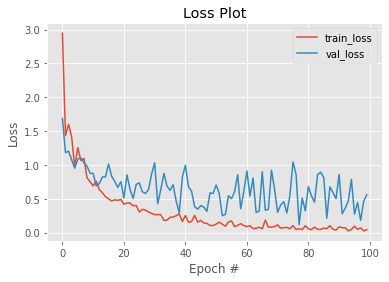

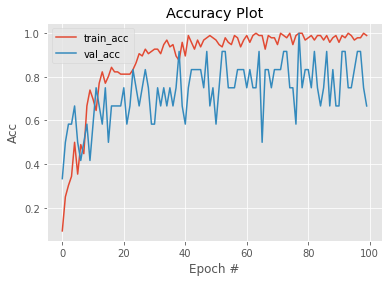

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), H.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), H.history["acc"], label="train_acc")
plt.plot(np.arange(0,100), H.history["val_acc"], label="val_acc")
plt.title("Accuracy Plot")
plt.xlabel("Epoch #")
plt.ylabel("Acc")
plt.legend()

plt.show()

In [31]:
ypred = model.predict(test_gen)
predictions = np.argmax(ypred, axis = 1)
# labels = (pred > 0.5).astype(np.int)
print(classification_report(test_gen.classes,predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      0.75      0.86         4
           2       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.93      0.92      0.92        12
weighted avg       0.93      0.92      0.92        12



In [ ]:
# model.save('PrakML_ModelInceptionResNetV2.h5')
# files.download('PrakML_ModelInceptionResNetV2.h5')